# Marker gene database maker
The purpose of this jupyter notebook is to run through a workflow of creating a blast database containing protein sequences of a given gene from a wide range of taxonomic groups that can be used to validate newly submitted sequences against. 

Broadly, this process involves the following steps: 

1. Starting with an Entrez query for the Gene database, download sequences and metadata for genes, transcripts and proteins using NCBI Datasets
2. Parse the data archive from step 1 to tabulate names and symbols for review
3. Parse the data archive from step 1 to tabulate variability in the sequence lengths for review 
4. Given a set of taxonomic group identifiers, tabulate the number of sequences for each group that are present in the data archive
5. Extract sequences from each taxonomic node and generate all-vs-all BLAST alignments 
6. Review the BLAST tabular output to make a list of accessions that are outliers or incorrect that need to be removed from the final BLAST database 
7. Generate a final BLAST database that can be used with VADR and other tools for validating newly submitted sequences.

## Download data

Sequence and metadata are downloaded using NCBI Datasets using an Entrez query provided by the user. 

In [22]:
import Bio
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
import sys

In [2]:
## specify Entrez query and output filename
entrez_query = 'arthropoda [ORGN] AND cytb [GENE] AND source mitochondrion [PROP] NOT rnatype mrna [PROP] NOT srcdb pdb [PROP] NOT uncultured NOT unverified NOT TPA'
email = 'mcveigh@ncbi.nlm.nih.gov'
output_file = 'ncbi_dataset.zip'

In [3]:
import scripts.obtain_gene_datasets as dl

gene_ids_file = 'gene_ids.txt'
dl.populate_gene_ids_file(entrez_query, email, gene_ids_file)
json_data = dl.format_file_data_into_json(gene_ids_file)
dl.obtain_gene_datasets(json_data, output_file)

Gene search for query 'arthropoda [ORGN] AND cytb [GENE] AND source mitochondrion [PROP] NOT rnatype mrna [PROP] NOT srcdb pdb [PROP] NOT uncultured NOT unverified NOT TPA' returned 2907 results


## Unzip Datasets archive

In [4]:
!unzip -o {output_file}

Archive:  ncbi_dataset.zip
  inflating: README.md               
  inflating: ncbi_dataset/data/protein.faa  
  inflating: ncbi_dataset/data/data_report.jsonl  
  inflating: ncbi_dataset/data/data_table.tsv  
  inflating: ncbi_dataset/data/dataset_catalog.json  


## Tabulate unique names

In [5]:
bdbag = 'ncbi_dataset/'
data_table = bdbag + 'data/data_table.tsv'
gene_names = 'gene_names.tsv'

In [6]:
%%bash -s {data_table} {gene_names}

data_table=$1
gene_names=$2

python3 scripts/unique.py ${data_table} > ${gene_names}

In [7]:
df = pd.read_csv(gene_names, sep='\t', header=None, names=['Gene Name', 'Count', 'Gene IDs'])
display(df.sort_values(by=['Count'], ascending=False))

,Gene Name,Count,Gene IDs
0,CYTB,2813,NaN


## Identify outliers based on protein size

In [72]:
pd.set_option('display.max_rows', 500)
data_table_df = pd.read_csv(data_table, sep='\t', index_col=1)
data_table_df.head(500)

,gene_symbol,description,scientific_name,common_name,tax_id,genomic_range,orientation,location,gene_type,transcript_accession,transcript_name,transcript_length,transcript_cds_coords,protein_accession,isoform_name,protein_length,protein_name
gene_id,,,,,,,,,,,,,,,,,
10002870,CYTB,cytochrome b,Entoria okinawaensis,Okinawa walking stick,590984,NC_014694.1:10236-11367,+,chr MT,PROTEIN_CODING,NaN,NaN,NaN,NaN,YP_004021616.1,NaN,377.0,cytochrome b
10043687,CYTB,cytochrome b,Grapholita molesta,oriental fruit moth,192188,NC_014806.1:10492-11637,+,chr MT,PROTEIN_CODING,NaN,NaN,NaN,NaN,YP_004072439.1,NaN,381.0,cytochrome b
10080123,CYTB,cytochrome b,Alpheus distinguendus,NaN,674293,NC_014883.1:8861-10018,+,chr MT,PROTEIN_CODING,NaN,NaN,NaN,NaN,YP_004123580.1,NaN,385.0,cytochrome b
10200253,CYTB,cytochrome b,Macrobrachium nipponense,NaN,159736,NC_015073.1:8926-10060,+,chr MT,PROTEIN_CODING,NaN,NaN,NaN,NaN,YP_004221780.1,NaN,378.0,cytochrome b
10200284,CYTB,cytochrome b,Pristomyrmex punctatus,NaN,507543,NC_015075.1:10890-11993,+,chr MT,PROTEIN_CODING,NaN,NaN,NaN,NaN,YP_004221807.1,NaN,367.0,cytochrome b
10200338,CYTB,cytochrome b,Culex pipiens pipiens,NaN,38569,NC_015079.1:10427-11561,+,chr MT,PROTEIN_CODING,NaN,NaN,NaN,NaN,YP_004221859.1,NaN,378.0,cytochrome b
10200767,CYTB,cytochrome b,Chrysoperla nipponensis,NaN,413239,NC_015093.1:10415-11551,+,chr MT,PROTEIN_CODING,NaN,NaN,NaN,NaN,YP_004222174.1,NaN,378.0,cytochrome b
10200819,CYTB,cytochrome b,Apochrysa matsumurae,NaN,417555,NC_015095.1:10401-11537,+,chr MT,PROTEIN_CODING,NaN,NaN,NaN,NaN,YP_004222200.1,NaN,378.0,cytochrome b
10210905,CYTB,cytochrome b,Bittacus pilicornis,NaN,172808,NC_015118.1:10354-11488,+,chr MT,PROTEIN_CODING,NaN,NaN,NaN,NaN,YP_004222774.1,NaN,378.0,cytochrome b


In [9]:
data_table_df[['transcript_length', 'protein_length']].describe()

,transcript_length,protein_length
count,0.0,2806.000000
mean,NaN,377.624376
std,NaN,4.990904
min,NaN,346.000000
25%,NaN,377.000000
50%,NaN,378.000000
75%,NaN,379.000000
max,NaN,411.000000


<AxesSubplot:xlabel='gene_symbol'>

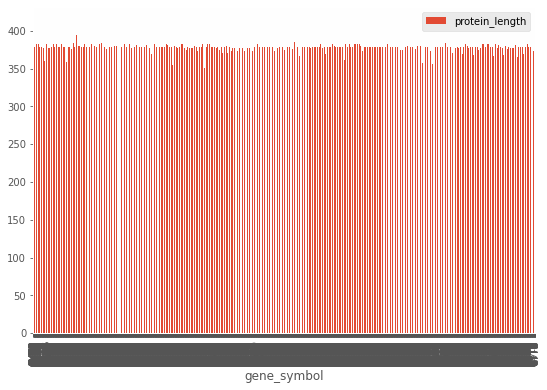

In [11]:
data_table_df.plot(kind='bar', y='protein_length', figsize=(9,6))

In [17]:
#identify sequences outside of length range for analsysis
wronglength = data_table_df.loc[(data_table_df['protein_length'] < 350) | (data_table_df['protein_length'] > 400)]
wronglength

,gene_id,description,scientific_name,common_name,tax_id,genomic_range,orientation,location,gene_type,transcript_accession,transcript_name,transcript_length,transcript_cds_coords,protein_accession,isoform_name,protein_length,protein_name
gene_symbol,,,,,,,,,,,,,,,,,
CYTB,22158292,cytochrome b,Pirata subpiraticus,NaN,330951,NC_025523.1:9589-10635,+,chr MT,PROTEIN_CODING,NaN,NaN,NaN,NaN,YP_009104758.1,NaN,348.0,cytochrome b
CYTB,26044919,cytochrome b,Megachile sculpturalis,NaN,1004196,NC_028017.1:10779-12014,+,chr MT,PROTEIN_CODING,NaN,NaN,NaN,NaN,YP_009170668.1,NaN,411.0,cytochrome b
CYTB,26833526,cytochrome b,Heterometrus longimanus,NaN,1719223,NC_029207.1:8705-9745,+,chr MT,PROTEIN_CODING,NaN,NaN,NaN,NaN,YP_009228517.1,NaN,346.0,cytochrome b


gene_symbol
CYTB    False
CYTB    False
CYTB    False
CYTB    False
CYTB    False
        ...  
CYTB    False
CYTB    False
CYTB    False
CYTB    False
CYTB    False
Name: protein_length, Length: 2813, dtype: bool

In [45]:
## filter out sequences that are either too long or too short

min_len = 350
max_len = 400

rightlength = data_table_df.loc[(data_table_df['protein_length'] > min_len) & (data_table_df['protein_length'] < max_len)]
rightlength.to_csv(data_table, sep='\t')
rightlength.head()
#acclist = rightlength['protein_accession']
rightlength.to_csv('taxmap', index=False, header=False, sep ='\t', columns=['protein_accession', 'tax_id'])
#print(acclist)

In [40]:
from Bio import SeqIO
sequences = [] 
#print(rejectlist_df['accession'])
for seq_record in SeqIO.parse("ncbi_dataset/data/protein.faa", "fasta"): 
    s = seq_record    
    if seq_record.id in rightlength['protein_accession'].tolist():
        sequences.append(s)
    else:
        print(seq_record.id)
SeqIO.write(sequences, "stripped.fsa", "fasta")  



YP_009104758.1
YP_009104533.1
YP_009228517.1
YP_009170668.1


2802

## SKIP THIS FOR NOW Extract sequences from specific taxonomic group(s) for further analysis

Analyzing all of the sequences using all-vs-all BLAST is time-consuming. In this step, we will group the sequences into broad taxonomic groups for further analysis. 

In [15]:
acclist_for_blast = 'acclist_for_blast.tsv'
taxids = !cut -f2 example_data/tax_nodes.tsv | head -n 2 | paste -s -d ','
print(taxids)


['6854,7215']


In [16]:
!python3 scripts/seqids_by_taxa.py --bdbag {bdbag} --taxids {taxids[0]} --output {acclist_for_blast} --email {email}
#!python3 scripts/seqids_by_taxa.py --bdbag {bdbag} --taxids 7215 --output {acclist_for_blast} --email {email}

Traceback (most recent call last):
  File "scripts/seqids_by_taxa.py", line 92, in <module>
    main()
  File "scripts/seqids_by_taxa.py", line 56, in main
    for protein in gene['proteins']:
KeyError: 'proteins'


## Run all-vs-all BLAST

In [46]:
#!scripts/blast_all.sh -b {bdbag} -a {acclist_for_blast} -t 6
os.system("makeblastdb -in stripped.fsa -parse_seqids -dbtype prot -taxid_map taxmap -out prot_blastdb")
os.system("blastp -db prot_blastdb -parse_deflines -num_threads 6 -query stripped.fsa -outfmt '7 std qcovs staxid ssciname' -out blastout.tsv")
#os.system("blast_formatter -archive blastout.asn -outfmt '7 std staxid ssciname' -out blastout.tsv")


0

acclist_for_blast.tsv


## Read BLAST tsv file, remove matches to self
This creates a master file of the blast output with the organism names and taxids
NOTE NaN values in the taxid and orgname are due to inconsistencies in the data formatting from data/data_table.tsv downloaded from datasets. Need to fix this

In [63]:
file_name_string = (r'blastout.tsv')
table_df = pd.read_csv(file_name_string,
                       sep='\t',
                       index_col=None,
                       low_memory=False,
                       usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],
                       header=None,
                       names=["queryseqid", "subjectseqid", "%identity", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "Evalue", "bitscore", "qcoverage", "taxid", "orgname"])
table_df = table_df[~table_df['queryseqid'].str.contains("#")]
table_df['%identity'] = pd.to_numeric(table_df['%identity'])
table_df['length'] = pd.to_numeric(table_df['length'])
table_df['qstart'] = pd.to_numeric(table_df['qstart'])
table_df['qend'] = pd.to_numeric(table_df['qend'])
table_df['sstart'] = pd.to_numeric(table_df['sstart'])
table_df['send'] = pd.to_numeric(table_df['send'])
table_df['qcoverage'] = pd.to_numeric(table_df['qcoverage'])

#strip .version if needed
#table_df['queryseqid'] = table_df['queryseqid'].astype(st
#table_df['queryseqid'] = table_df['queryseqid'].map(lambda x: str(x)[:-1])
table2_df = table_df.loc[(table_df['queryseqid']) != (table_df['subjectseqid'])]
table2_df

,queryseqid,subjectseqid,%identity,length,mismatch,gapopen,qstart,qend,sstart,send,Evalue,bitscore,qcoverage,taxid,orgname
5,NP_008080.1,YP_009176739.1,100.000,378.0,0.0,0.0,1.0,378.0,1.0,378.0,0.0,758.0,100.0,30066.0,Anopheles merus
6,NP_008080.1,YP_009176635.1,100.000,378.0,0.0,0.0,1.0,378.0,1.0,378.0,0.0,758.0,100.0,7173.0,Anopheles arabiensis
8,NP_008080.1,YP_009176700.1,99.471,378.0,2.0,0.0,1.0,378.0,1.0,378.0,0.0,756.0,100.0,199890.0,Anopheles epiroticus
9,NP_008080.1,YP_009176726.1,99.735,378.0,1.0,0.0,1.0,378.0,1.0,378.0,0.0,756.0,100.0,34690.0,Anopheles melas
10,NP_008080.1,YP_009176674.1,99.471,378.0,2.0,0.0,1.0,378.0,1.0,378.0,0.0,755.0,100.0,1518534.0,Anopheles coluzzii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415019,YP_003204862.1,YP_009111460.1,72.340,376.0,103.0,1.0,1.0,375.0,1.0,376.0,0.0,570.0,99.0,286173.0,Asiotmethis jubatus
1415020,YP_003204862.1,YP_006883042.1,73.995,373.0,96.0,1.0,4.0,375.0,7.0,379.0,0.0,569.0,98.0,941637.0,Acleris fimbriana
1415021,YP_003204862.1,YP_009447611.1,75.532,376.0,91.0,1.0,1.0,375.0,1.0,376.0,0.0,569.0,99.0,1980559.0,Carabus lafossei
1415022,YP_003204862.1,YP_009469522.1,75.000,376.0,93.0,1.0,1.0,375.0,1.0,376.0,0.0,569.0,99.0,1073095.0,Hydrotaea ignava


## Create a smaller dataframe with just numberical values

In [64]:
dftidy = table2_df.drop(['mismatch', 'gapopen', 'bitscore', 'taxid', 'orgname'], axis=1)
dftidy

,queryseqid,subjectseqid,%identity,length,qstart,qend,sstart,send,Evalue,qcoverage
5,NP_008080.1,YP_009176739.1,100.000,378.0,1.0,378.0,1.0,378.0,0.0,100.0
6,NP_008080.1,YP_009176635.1,100.000,378.0,1.0,378.0,1.0,378.0,0.0,100.0
8,NP_008080.1,YP_009176700.1,99.471,378.0,1.0,378.0,1.0,378.0,0.0,100.0
9,NP_008080.1,YP_009176726.1,99.735,378.0,1.0,378.0,1.0,378.0,0.0,100.0
10,NP_008080.1,YP_009176674.1,99.471,378.0,1.0,378.0,1.0,378.0,0.0,100.0
...,...,...,...,...,...,...,...,...,...,...
1415019,YP_003204862.1,YP_009111460.1,72.340,376.0,1.0,375.0,1.0,376.0,0.0,99.0
1415020,YP_003204862.1,YP_006883042.1,73.995,373.0,4.0,375.0,7.0,379.0,0.0,98.0
1415021,YP_003204862.1,YP_009447611.1,75.532,376.0,1.0,375.0,1.0,376.0,0.0,99.0
1415022,YP_003204862.1,YP_009469522.1,75.000,376.0,1.0,375.0,1.0,376.0,0.0,99.0


Groupby and Aggregate the top ten rows of blast results

In [65]:
table3_df = dftidy.groupby('queryseqid').head(10) 
ident_group = table3_df.groupby('queryseqid').agg(['mean', 'min', 'max']) 
ident_group

%identity                  length               qstart            \
                 mean     min      max   mean    min    max   mean  min  max   
queryseqid                                                                     
NP_006913.1   95.8464  91.534   99.735  378.0  378.0  378.0    1.0  1.0  1.0   
NP_007119.1   80.3776  72.872   92.819  375.7  373.0  376.0    6.3  6.0  9.0   
NP_007301.1   93.8939  91.293   99.208  378.4  378.0  379.0    1.0  1.0  1.0   
NP_008080.1   99.4443  98.677  100.000  378.0  378.0  378.0    1.0  1.0  1.0   
NP_008093.1   87.4424  69.737   99.217  380.1  379.0  383.0    1.0  1.0  1.0   
...               ...     ...      ...    ...    ...    ...    ...  ...  ...   
YP_961309.1   90.3429  89.182   92.084  379.0  379.0  379.0    1.0  1.0  1.0   
YP_961393.1   99.2855  98.148  100.000  378.0  378.0  378.0    1.0  1.0  1.0   
YP_973126.1   92.0633  86.508   98.677  378.0  378.0  378.0    1.0  1.0  1.0   
YP_973139.1   87.4867  87.037   88.095  378.0  378.0  378.0    1.0  1.0  1.0   
YP_973152.1   89.9205  88.889   96.032  378.0  378.0  378.0    1.0  1.0  1.0   

              qend  ... sstart   send               Evalue            \
              mean  ...    max   mean    min    max   mean  min  max   
queryseqid          ...                                                
NP_006913.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
NP_007119.1  381.0  ...    5.0  376.2  376.0  377.0    0.0  0.0  0.0   
NP_007301.1  378.4  ...    1.0  378.4  378.0  379.0    0.0  0.0  0.0   
NP_008080.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
NP_008093.1  379.9  ...    1.0  380.1  379.0  383.0    0.0  0.0  0.0   
...            ...  ...    ...    ...    ...    ...    ...  ...  ...   
YP_961309.1  379.0  ...    1.0  379.0  379.0  379.0    0.0  0.0  0.0   
YP_961393.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
YP_973126.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
YP_973139.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
YP_973152.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   

            qcoverage                
                 mean    min    max  
queryseqid                           
NP_006913.1     100.0  100.0  100.0  
NP_007119.1      98.9   98.0   99.0  
NP_007301.1      99.4   99.0  100.0  
NP_008080.1     100.0  100.0  100.0  
NP_008093.1      99.1   99.0  100.0  
...               ...    ...    ...  
YP_961309.1     100.0  100.0  100.0  
YP_961393.1     100.0  100.0  100.0  
YP_973126.1     100.0  100.0  100.0  
YP_973139.1     100.0  100.0  100.0  
YP_973152.1     100.0  100.0  100.0  

[2802 rows x 24 columns]

Check % identity and query coverage summary to set pass/fail thresholds

In [36]:
identity_low = ident_group[ident_group['%identity','max'] <82 ].index.tolist()
identity_low

['YP_637022.1']

In [33]:
qcov_low = ident_group[ident_group['qcoverage','min'] < 99].index.tolist()
qcov_low 

[]

## Sort fasta file creating two files [1] seqs that pass [2] seqs that fail

In [34]:
from Bio import SeqIO
sequences = [] 
fail_sequence = []
for seq_record in SeqIO.parse("1437010_input.fa", "fasta"):
    s = seq_record
    if seq_record.id in identity_low:
        #fail_sequence.append(s)
        print("fails seq identity test", seq_record.id)
        fail_sequence.append(s)
    if seq_record.id in qcov_low:
        fail_sequence.append(s)
        print("fails qcov test",seq_record.id)
    else:
        sequences.append(s)
        print(seq_record.id)
        
SeqIO.write(sequences, "outputfile", "fasta")

NP_871760.1
NP_904340.1
YP_665641.1
NP_941390.1
NP_976125.1
NP_976138.1
NP_976112.1
NP_976099.1
YP_026116.1
YP_052709.1
YP_001218803.1
YP_209217.1
YP_214952.1
YP_220575.1
YP_220562.1
YP_238254.1
YP_337836.1
YP_448958.1
YP_537157.1
YP_537131.1
YP_626406.1
YP_626740.1
YP_626727.1
YP_654274.1
YP_784008.1
YP_003024038.1
YP_961407.1
YP_973114.1
YP_001023775.1
YP_001260511.1
YP_001315071.1
YP_001315084.2
YP_001427434.1
YP_001427421.1
YP_001488954.1
YP_001686710.1
YP_001874852.1
YP_001874865.1
YP_001874813.1
YP_001876481.1
YP_002117879.1
YP_002120670.1
YP_002124314.2
YP_002221512.1
YP_002302312.1
YP_002456358.1
YP_002456371.1
YP_002601084.1
YP_002791041.1
YP_002791054.1
NP_068794.1
NP_071654.1
NP_071696.1
NP_148750.1
NP_149460.1
NP_149969.1
NP_008483.1
NP_659248.1
NP_006940.1
NP_007081.1
NP_007172.1
NP_008198.1
NP_008211.1
NP_008224.1
NP_008237.1
NP_008263.1
NP_007380.1
NP_007393.1
NP_007445.1
NP_007561.1
NP_008418.1
NP_007808.1
NP_007847.1
NP_008646.1
NP_037661.1
YP_003208313.1
YP_003331067.

YP_009466951.1
YP_009466964.1
YP_009466977.1
YP_009468711.1
YP_009468939.1
YP_009469091.1
YP_009475812.1
YP_009479754.1
YP_009487344.1
YP_006702561.1
YP_007001316.1
YP_007024968.1
YP_007024981.1
fails seq identity test YP_007026097.1
YP_007026097.1
YP_007625249.1
YP_007625288.1
YP_007625314.1
YP_007625327.1
YP_007625340.1
YP_007625353.1
YP_007625366.1
YP_007625379.1
YP_007625392.1
YP_007626809.1
YP_007626796.1
YP_007626770.1
YP_007626783.1
YP_008080692.1
YP_008080913.1
YP_008081955.1
YP_008081968.1
YP_008082933.1
YP_008379332.1
YP_008963579.1
YP_008965266.1
YP_008992416.1
YP_008993954.1
YP_008994667.1
YP_008999722.1
YP_009002197.1
YP_009003997.1
YP_009019452.1
YP_009020696.1
YP_009024865.1
YP_009024995.1
YP_009025008.1
YP_009024092.1
YP_009027705.1
YP_009027718.1
YP_009034049.1
YP_009040283.1
YP_009104668.1
YP_009107107.1
fails seq identity test YP_009109991.1
YP_009109991.1
YP_009110004.1
YP_009111435.1
YP_009113490.1
YP_009120882.1
YP_009120895.1
YP_009133139.1
YP_009136183.1
YP_0091

1143

In [35]:
fh = open("outputfile")
n = 0
for line in fh:
    if line.startswith(">"):
        n += 1
fh.close()
print("Number of sequences passing blast filter and saved to outputfile:", n)

Number of sequences passing blast filter and saved to outputfile: 1143


## SKIP THIS FOR NOW Create final BLAST database. Needs to be changed

In [33]:
final_acclist = 'final_acclist.txt'
filename_prefix = 'cytb_genes'

In [34]:
!scripts/make_finaldb.sh -b {bdbag} -a {final_acclist} -p {filename_prefix} -t 6

Tue Oct 27 16:23:29 EDT 2020 Filtering protein fasta...
Tue Oct 27 16:23:30 EDT 2020 Create a BLAST database...


Building a new DB, current time: 10/27/2020 16:23:30
New DB name:   /home/mcveigh/notebook/Marker-Gene-Validator/cytb_genes_blastdb
New DB title:  cytb_genes.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /home/mcveigh/notebook/Marker-Gene-Validator/cytb_genes_blastdb
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 74 sequences in 0.037137 seconds.


